# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Table of contents

1. [Importing libaries & dataset](#data)
2. Explore and clean data :
    [portfolio](#portfolio)
    [profile](#profile)
    [transcript](#transcript)
3. [Exploratory analysis](#explore)
4. [Modeling](#model)
5. [Conclusion](#conclude)


<font color="orangered">Starts from <strong>Exploratory analysis</strong> part if you want to skip the data cleaning and jump right into the analysis part</font>

<a id="data"></a>
# `SECTION 1`

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import os.path

%matplotlib inline
%config Completer.use_jedi = False # autocomplete

## Importing data

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

---
# `SECTION 2` Exploring & cleaning data

There are three dataset to explore and clean.

<a id="portfolio"></a>
## `DATA 1` portfolio

In [4]:
portfolio.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


#### Commentary

There are only 10 offers available in the data as it is a simplified version. 

For cleaning, note the following:
- no missing value exists
- date types look okay
- need to destructure `channels` column as it is list <font color="orangered">(to do)</font>
- just confirm if there is any duplicates <font color="orangered">(to do)</font>

After cleaning, I would like to return:
- a grouped by table that shows summary statistics of offers by `offer_type`

### Function to clean `portfolio` data

In [13]:
def clean_portfolio(df):
    ''' Clean the 'portolio' dataset, achieving :
    1. Destructure 'channels' column
    2. Drop 'channels' column after destructing
    
    INPUT: a Pandas dataframe that contains portfolio data
    OUTPUT: a clean dataframe 
    '''
    
    # Get unique channels 
    temp_list = list()

    for _type in df.channels:
        temp_list.extend(_type)

    channel_list = set(temp_list)
    
    
    # Create binary tables for channels
    channel_bool = dict()

    for _type in channel_list:
        channel_bool[_type] = df.channels.apply(lambda x: _type in x)
    
    channel_df = pd.DataFrame(channel_bool)
    
    
    # Transform boolean to binary integer (True: 1, False: 0)
    binary_rule = {True: 1, False: 0}
    
    for col in channel_df.columns:
        channel_df[col] = channel_df[col].map(binary_rule) 
       
    # Join the binary columns to the original dataframe
    df_clean = df.join(channel_df)
    
    # Drop 'channels' columns
    df_clean = df_clean.drop(columns='channels')
    
    
    return df_clean
    

In [15]:
# Clean portfolio dataframe
portfolio_v1 = clean_portfolio(portfolio)
portfolio_v1

,reward,difficulty,duration,offer_type,id,web,email,social,mobile
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [17]:
# Check for duplicates
assert portfolio_v1.duplicated().sum() == 0, "There is at least one duplicated offer"

In [19]:
# Printing stats table including channels
portfolio_v1.groupby('offer_type').mean()

,reward,difficulty,duration,web,email,social,mobile
offer_type,,,,,,,
bogo,7.5,7.50,6.0,0.75,1.0,0.75,1.00
discount,3.0,11.75,8.5,1.00,1.0,0.50,0.75
informational,0.0,0.00,3.5,0.50,1.0,0.50,1.00


#### Commentary:

Customers gets the most reward from `bogo` it is less difficult to redeem than `discount` which requires more spends. 

When sending out offers, `email` is opted always. `bogo` looks the most aggressive offer utilising the 4 channels the most (just as it sounds).

In [20]:
# Saving the cleand dataframe as 'portfolio_v1'
portfolio_v1.to_csv('data/portfolio_v1.csv', index=False)

<a id="profile"></a>
## `DATA 2` profile

In [12]:
profile.head(3) 

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN


In [13]:
profile.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [24]:
# Check for duplicates by id
assert profile.duplicated(subset='id').sum() == 0, "There is at least one duplicated record"

In [14]:
# 2175 records with null data 
# age of 118 is odd so to remove
print(profile[profile.gender.isnull()].head(3))
profile[profile.gender.isnull()].age.value_counts() 

  gender  age                                id  became_member_on  income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212     NaN
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712     NaN
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804     NaN


118    2175
Name: age, dtype: int64

#### Commentary

There is no duplicated id. `profile` data contains all unique user ids.

For cleaning, note the following:
- 2175 missing value exists in `gender`, `income` columns: contain age of 118 which is abnormal <font color="orangered">(drop them) - 12.7% of the data</font>
- `become_member_on` to be converted to datetime object

### Function to clean `profile` data

In [48]:
def clean_profile(df):
    ''' Clean the 'portolio' dataset, achieving :
    1. Drop nulls
    2. Convert 'become_member_on' to datetime object
    
    INPUT: a Pandas dataframe that contains profile data
    OUTPUT: a clean dataframe 
    '''
    
    # Copy the original dataframe
    df_clean = df.copy()
    
    # Drop nulls
    df_clean = df_clean[df_clean.gender.notnull()]
    
    # Convert to datetime object
    df_clean.loc[:, 'became_member_on'] = pd.to_datetime(df_clean.became_member_on, format="%Y%m%d")
    
    return df_clean


In [50]:
profile_v1 = clean_profile(profile)
profile_v1.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


In [53]:
# Check for any remaining null data 
assert profile_v1.shape[0] == profile.shape[0] - 2175, "It looks that missing values are not dropped correctly"
assert profile_v1.isnull().sum().sum() == 0, "There still is missing value"

In [55]:
# Save the clean data as profile_v1
profile_v1.to_csv('data/profile_v1.csv', index=False)

<a id="transcript"></a>
## `DATA 3` transcript

In [59]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [60]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [7]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

### Quick inspection of the `value` column

In [4]:
# Destructoring dictionary in 'value' column 
temp = transcript.copy()

In [5]:
# Extract unique keys from the dictionary
value_keys = []

for _dict in temp.value:
    for keys in _dict.keys():
        value_keys.append(keys)
        
print(set(value_keys))

{'offer id', 'offer_id', 'reward', 'amount'}


#### Commentary

There are 3 unique keys in the dictionary, while `offer_id` and `offer id` should give the same information. 

- We need destructuring the dictionary first 
- Then combine `offer_id` and `offer id` column together into `offer_id` column
- drop `offer id` column

In [22]:
# Quick way to destructure using 'json_normalize' method
value_destructured = pd.json_normalize(temp['value'])
value_destructured

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
...,...,...,...,...
306529,NaN,1.59,NaN,NaN
306530,NaN,9.53,NaN,NaN
306531,NaN,3.61,NaN,NaN
306532,NaN,3.53,NaN,NaN


In [25]:
# Merge 'offer_id' and 'offer id' columns 
# np.where(condition, value if true, value if false)
value_destructured['offer_id'] = np.where(value_destructured['offer id'].notnull(), 
                                          value_destructured['offer id'], 
                                          value_destructured['offer_id'])

# Drop the unnecessary offer id column if merger successful
assert value_destructured['offer_id'].notnull().sum() == 167581, "It is an incorrect merge"
value_destructured = value_destructured.drop(columns='offer id')

Number of transactions made:  138953

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64


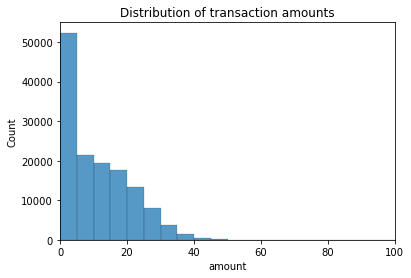

In [26]:
# Inspecting amount column
print('Number of transactions made: ', value_destructured.amount.notnull().sum(), end='\n\n')
print(value_destructured.amount.describe())

sns.histplot(x=value_destructured.amount, binwidth=5); # every $5
plt.title('Distribution of transaction amounts');
plt.xlim([0,100]); # removing outliers i.e. max value of $1062.28

In [28]:
# Transation value over $100 (hidden from the graph above)
print(f'#trans over $100: {(value_destructured.amount > 100).sum()}')
print(f'  in percentage: {(value_destructured.amount > 100).sum() / 138953 * 100:.2f}%')

#trans over $100: 478
  in percentage: 0.34%


Most of the amounts fall below $100 with some outliers that are minor enough to be ignored. Note that transaction values here includes those purchased with no offers as well.

Total number of rewards given: 306534


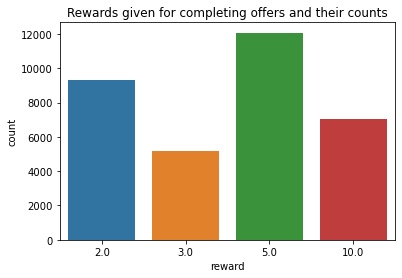

In [105]:
# Inspecting reward column
print('Total number of rewards given:', len(value_destructured.reward.notnull()))

sns.countplot(x=value_destructured.reward);
plt.title('Rewards given for completing offers and their counts');

Rewards are given for offers that are completed. Therefore, it must correspond to `offer completed` events only. Reward 5 has been given the most followed by reward 2. 

#### Commentary - `transcript` data:

There are four types of event following marketing funnels. As mentioned earlier an offer can be completed without receiving / viewing offer. Also, transaction can happen with no offer redeemed.

No missing data is found in `transcript` data. However, after destructuring `value` column many null values are generated, which is to address no transactions / rewards and delivers a correct picture - no need to drop.
 
For cleaning, 
- destructor dictionary in `value` column <font color="orangered">(to do)</font>
- make the keys of the ditionary in `value` column consistent <font color="orangered">(to do)</font>
- drop the original `value` column <font color="orangered">(to do)</font>

### Function to clean `transcript` data

In [33]:
def clean_transcript(df):
    ''' Clean the 'transcript' dataset, achieving :
    1. Destructure dictionary in 'value' column & create a new dataframe
    2. Ensure consistency by merging offer_id with offer id column
    3. Drop the duplicated offer id column
    3. Join the new dataframe to the original transcript dataframe
    4. Drop the original 'value' column

    INPUT: a Pandas dataframe that contains transcript data
    OUTPUT: a clean dataframe 
    '''
    
    # Instantiate df_clean as a copy of df
    df_clean = df.copy()
    
    # Destructoring dictionary in 'value' column 
    value_df = pd.json_normalize(df.value)
    
    # Making values in 'value_key' column consistent + testing the result
    # 'offer id' column merged 'offer_id' & test the change

    # For testing, the merged column size should match sum of count 1 & 2
    count1 = value_df['offer_id'].notnull().sum()
    count2 = value_df['offer id'].notnull().sum()
    
    value_df['offer_id'] = np.where(value_df['offer id'].notnull(), 
                                    value_df['offer id'], value_df['offer_id'])
    
    # Testing if merged successfully
    assert value_df['offer_id'].notnull().sum() == count1 + count2
    
    # Drop offer id column
    value_df = value_df.drop(columns='offer id')

    df_clean = df_clean.join(value_df)
    
    # Drop the original 'value' column
    df_clean = df_clean.drop(columns='value')
    
    
    return df_clean
    

In [34]:
# Returning the clean dataframe
transcript_v1 = clean_transcript(transcript)
transcript_v1

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,NaN,NaN


### Post cleaning inspection for `transcript_v1`

In [38]:
# If there is a value in 'amount', it should be about transaction
assert transcript_v1[transcript_v1.amount.notnull()].event.unique()[0] == 'transaction'

In [39]:
# Check for duplicates by 'person' and 'value_key'
transript_v1_duplicated = transcript_v1[transcript_v1.duplicated(keep=False)]
transript_v1_duplicated

,person,event,time,amount,offer_id,reward
66122,3dde94fa581145cb9f206624f1a94d5a,offer completed,168,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
66123,3dde94fa581145cb9f206624f1a94d5a,offer completed,168,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
66782,e9fb6ed2cecb4980ba98c86abc9c91e3,offer completed,168,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0
66783,e9fb6ed2cecb4980ba98c86abc9c91e3,offer completed,168,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0
67613,a7dc060f6fc94ca7bf71fbb188187dca,offer completed,168,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
...,...,...,...,...,...,...
304756,0785f1fce0b04ba08e01c7d2ebab4917,offer completed,708,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0
305550,b7e216b6472b46648272c29a52a86702,offer completed,714,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
305551,b7e216b6472b46648272c29a52a86702,offer completed,714,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
306455,f3e801caeafe4899b3b989b586e74ac7,offer completed,714,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0


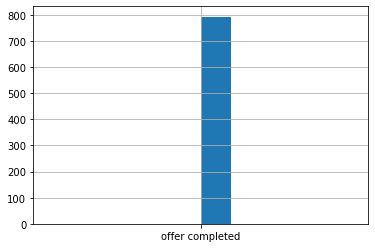

In [40]:
# Duplicated event 
transript_v1_duplicated.event.hist();

In [41]:
# Inspection for duplicates with a sample 
sample = transcript_v1[transcript_v1.person == 'b7e216b6472b46648272c29a52a86702']
sample

,person,event,time,amount,offer_id,reward
1730,b7e216b6472b46648272c29a52a86702,offer received,0,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
18395,b7e216b6472b46648272c29a52a86702,offer viewed,12,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
48674,b7e216b6472b46648272c29a52a86702,transaction,138,26.84,NaN,NaN
48675,b7e216b6472b46648272c29a52a86702,offer completed,138,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0
54929,b7e216b6472b46648272c29a52a86702,offer received,168,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
69704,b7e216b6472b46648272c29a52a86702,offer viewed,174,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
93867,b7e216b6472b46648272c29a52a86702,transaction,246,33.44,NaN,NaN
93868,b7e216b6472b46648272c29a52a86702,offer completed,246,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0
112546,b7e216b6472b46648272c29a52a86702,offer received,336,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
149137,b7e216b6472b46648272c29a52a86702,offer viewed,402,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN


#### Commentary
About 397 fields (793 rows / 2) have duplicated records and it happends for `offer completed` event only. 

The above sample data shows the same type of duplication (idx# 305550, 305551). The duplicated fields do not really convery any meaningful data so drop duplicates (keep first).

### Drop duplicates in `transcript_v1`

In [42]:
print(f'Before dropping duplicates: {transcript_v1.shape[0]} records')
print(f'Total {transcript_v1.duplicated().sum()} duplicates exist')

Before dropping duplicates: 306534 records
Total 397 duplicates exist


In [43]:
transcript_v1 = transcript_v1.drop_duplicates(keep='first')

In [44]:
# Confirm the changes
assert transcript_v1.shape[0] == 306534 - 397, "There is something wrong"

### Re-order event
It is understood that when an offer is completed, it follows funnles like below:  
    
    'offer received' -> 'offer viewed' ->'transaction' -> 'offer completed'
    
For later use, it is reasonable to make the `event` column categorical (ordered).

In [67]:
funnel = ['offer received', 'offer viewed', 'transaction', 'offer completed']
transcript_v1.loc[:, 'event'] = pd.Categorical(transcript_v1.event, categories=funnel, ordered=True)

In [69]:
transcript_v1.event # it is now categorical ordered!

0         offer received
1         offer received
2         offer received
3         offer received
4         offer received
               ...      
306529       transaction
306530       transaction
306531       transaction
306532       transaction
306533       transaction
Name: event, Length: 306137, dtype: category
Categories (4, object): ['offer received' < 'offer viewed' < 'transaction' < 'offer completed']

In [70]:
# Save the clean data as transcript_v1
transcript_v1.to_csv('data/transcript_v1.csv', index=False)

---
<a id="explore"></a>
# `SECTION 3` Exploratory analysis

In [75]:
# Load the clean dataset
portfolio_v1 = pd.read_csv('data/portfolio_v1.csv')
profile_v1 = pd.read_csv('data/profile_v1.csv')
transcript_v1 = pd.read_csv('data/transcript_v1.csv')